In [1]:
import sys
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import torch
import weightwatcher as ww
import powerlaw
import numpy as np

2022-10-16 21:30:03.593694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 21:30:03.813840: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-16 21:30:04.544315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64:/usr/local/cuda-10.2/lib64:
2022-10-16 21:30:04.544440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

In [2]:
print(ww.__file__)
print(ww.__version__)
print(powerlaw.__file__)
print(powerlaw.__version__)

/data/yyaoqing/anaconda3/envs/NLP_metrics/lib/python3.8/site-packages/weightwatcher/__init__.py
0.5.6
/data/yyaoqing/anaconda3/envs/NLP_metrics/lib/python3.8/site-packages/powerlaw.py
1.5


In [3]:
blue, yellow, red = '#91bfdb', '#ffffbf', '#fc8d59'

In [4]:
def plot_loghist(x, bins, xmin):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, density=True, color=blue)

    if xmin:
        plt.axvline(xmin, color='r', label=r'$x_{min}$')

    plt.xscale('log')

In [5]:
def plot_result_new(distribution, id, fig_title, xlim):
    
    # Get evals   
    evals = np.load(f'{fig_title}_evals.npy')
        
    # Fit evals
    EVALS_THRESH = 0.00001
    if id !=0:
        # Fit truncated powerlaw to this distribution using fix finger
        nz_evals = evals[evals > EVALS_THRESH]
        xmax = np.max(evals)
        num_bins = 100  # np.min([100, len(nz_evals)])
        h = np.histogram(np.log10(nz_evals), bins=num_bins)
        ih = np.argmax(h[0])
        xmin2 = 10 ** h[1][ih]
        xmin_range = (0.95 * xmin2, 1.05 * xmin2)
        fit = powerlaw.Fit(evals, xmin=xmin_range, xmax=xmax, verbose=False, xmin_distribution=distribution)
        
    else:
        # Fit ordinary powerlaw
        xmax = np.max(evals)
        nz_evals = evals[evals > EVALS_THRESH]
        fit = powerlaw.Fit(nz_evals, xmax=xmax, verbose=False)

    # Plot evals
    xmin = fit.xmin
    xmax = fit.xmax

    fig2 = fit.plot_pdf(color='b', linewidth=0) # invisbile
    #plot_loghist(evals[evals>(xmin/100)], bins=100, xmin=xmin)
    plot_loghist(evals, bins=100, xmin=xmin)
    fig2 = fit.plot_pdf(color='r', linewidth=2)
    if distribution == "power_law":
        fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig2)
    elif distribution == "truncated_power_law":
        fit.truncated_power_law.plot_pdf(color='r', linestyle='--', ax=fig2)
    elif distribution == "exponential":
        fit.exponential.plot_pdf(color='r', linestyle='--', ax=fig2)
    elif distribution == "lognormal":
        fit.lognormal.plot_pdf(color='r', linestyle='--', ax=fig2)

    fig2.set_xlabel("Eigenvalues of correlation matrix", fontsize=14)
    fig2.set_ylabel("ESD", fontsize=14)
    fig2.figure.set_size_inches(3.8, 3.2)
    
    fig2.set_xlim(xlim)
    fig2.set_ylim([0.0001, 10])
    plt.legend()

    alpha = "{:.2f}".format(fit.alpha)
    KS = "{:.2f}".format(fit.D)
    if distribution in ["truncated_power_law", "exponential"]:
        exp = "{:.2f}".format(fit.truncated_power_law.Lambda)
    sigma = "{:.2f}".format(fit.sigma)
    
    if id==0:
        title = f"alpha={alpha}, ks_distance={KS}"
    elif id==1:
        title = f"E-TPL beta={alpha}, ks_distance={KS}" + f"\n E-TPL lambda={exp}"
    elif id==2:
        title = f"sigma={sigma}, ks_distance={KS}"
    elif id==3:
        title = f"exponent={exp}, ks_distance={KS}"        
            
    plt.title(title, fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f"{fig_title}_{id}.pdf", dpi=300, format='pdf')
    plt.show()
    plt.clf()

In [6]:
dataset="WMT"
plt.rcParams['figure.dpi'] = 300
experiment_type="sample"
width=512
training_type="normal"
num_layers = 6

distributions = ["power_law", "truncated_power_law", "lognormal", "exponential"]

# Good PL fitting

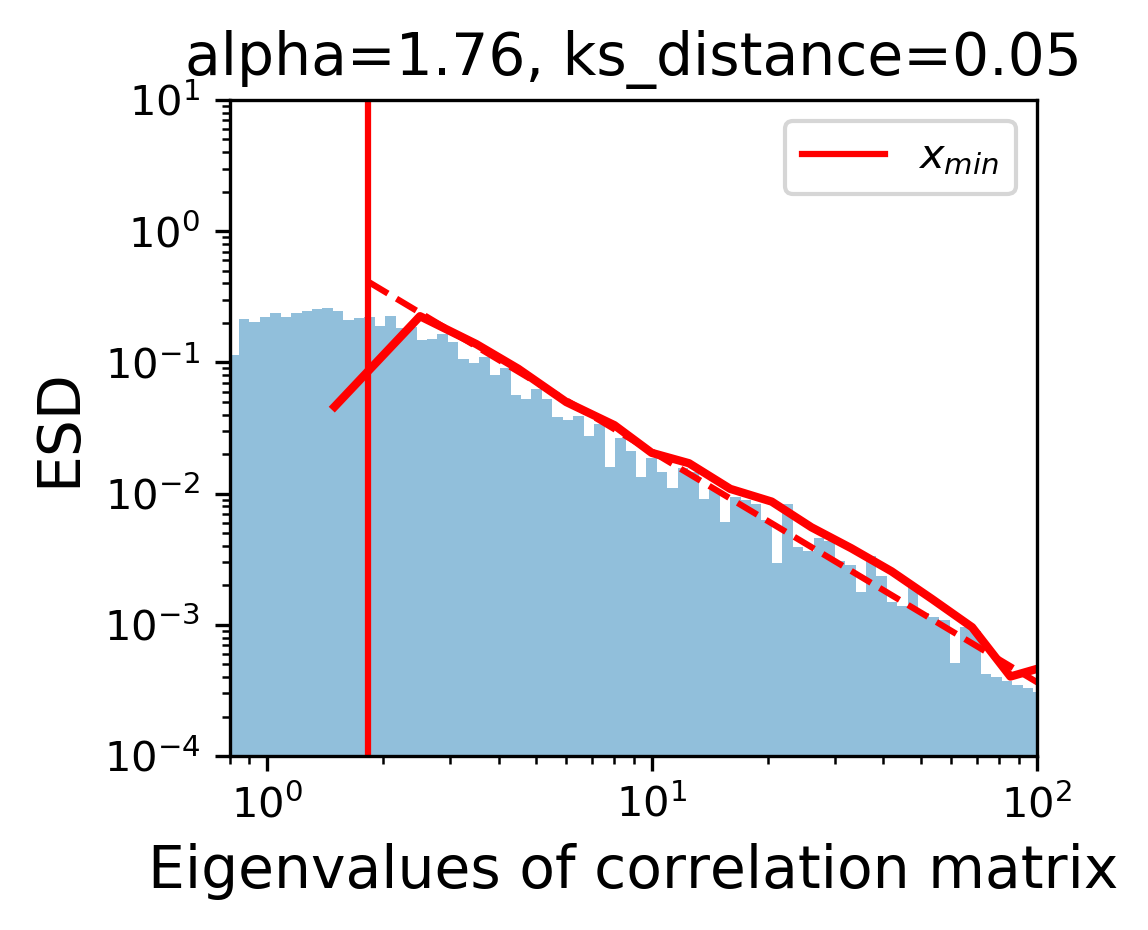

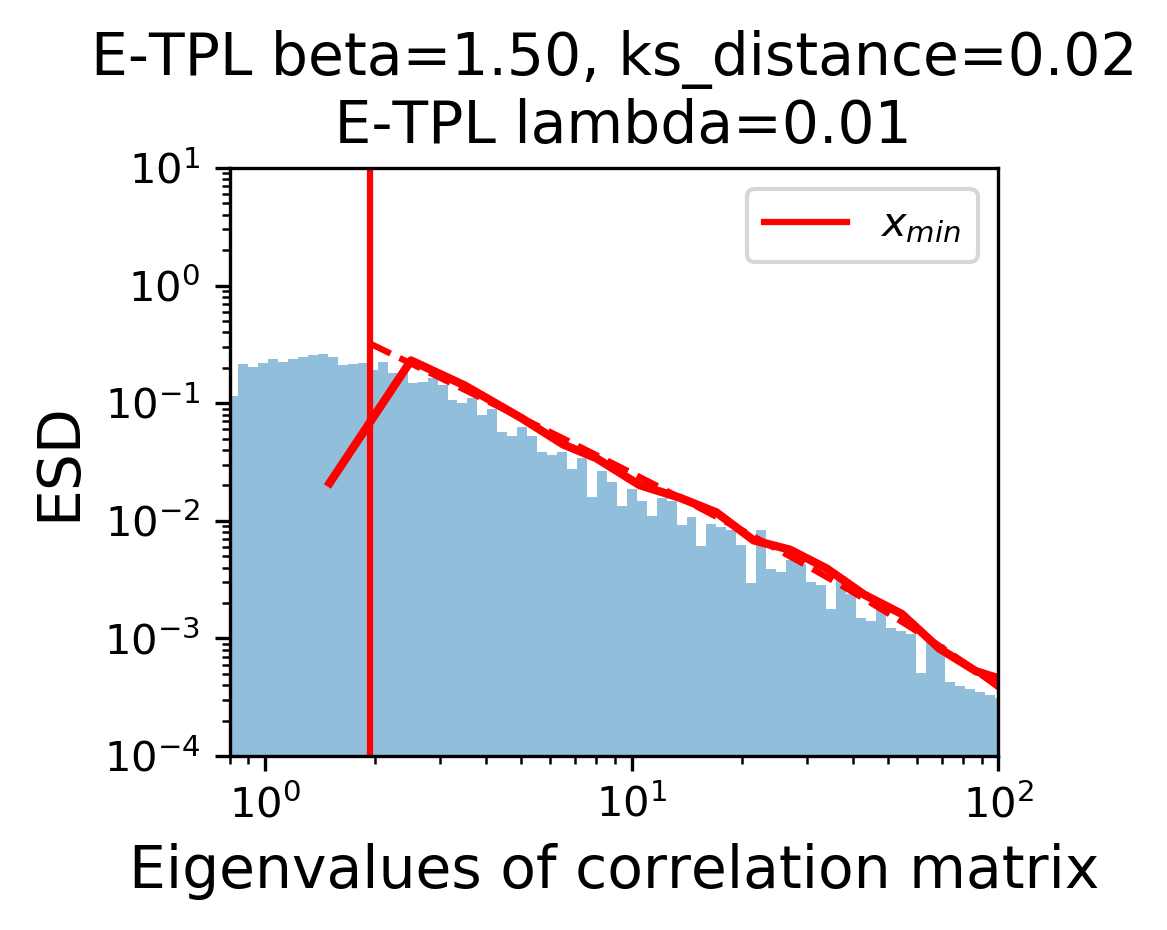

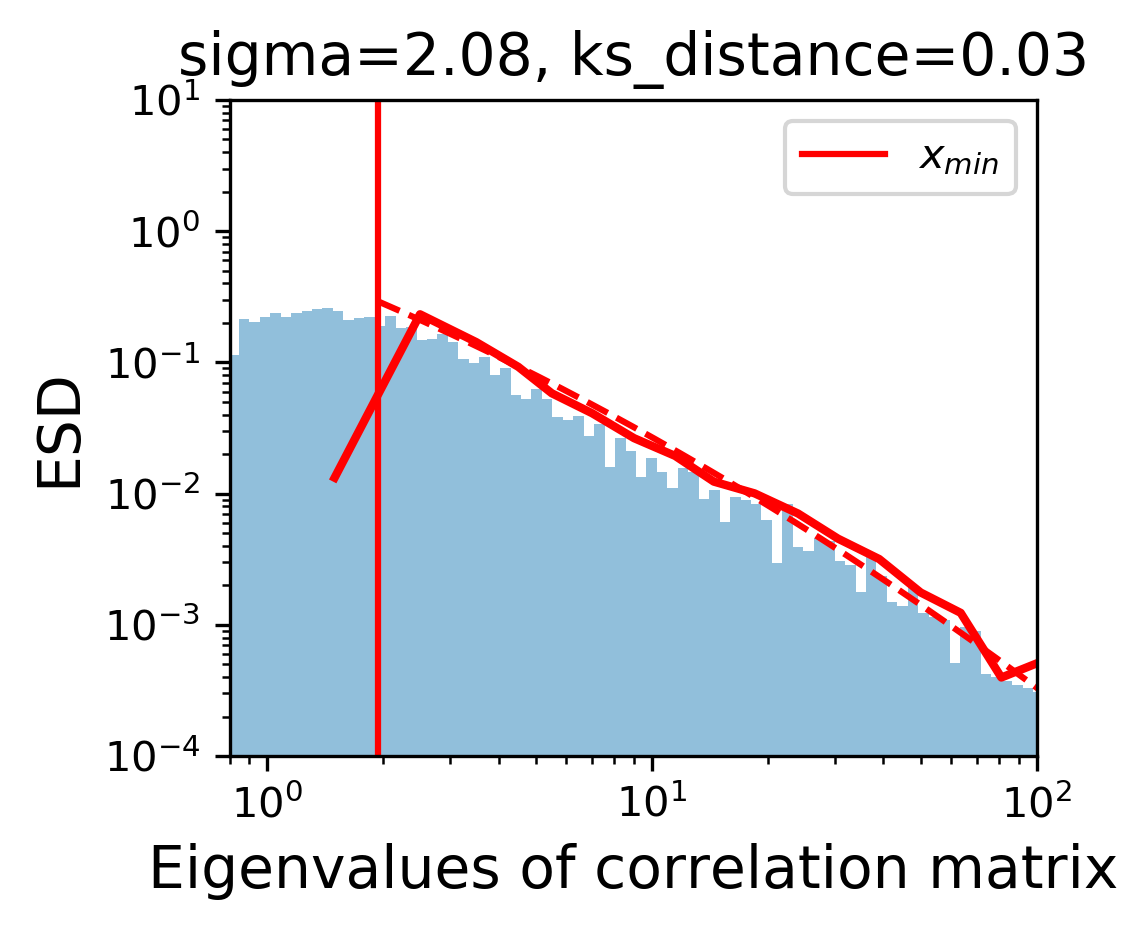

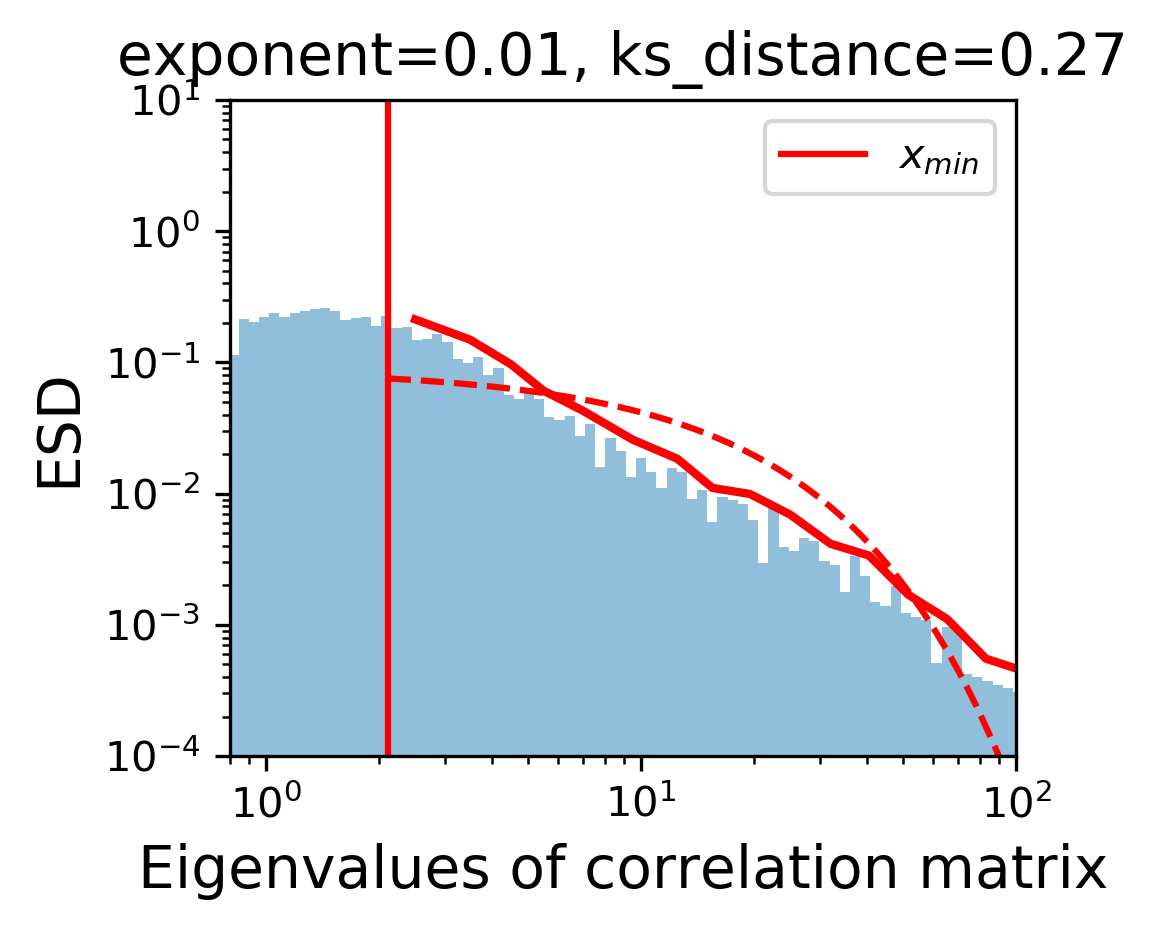

<Figure size 1920x1440 with 0 Axes>

In [7]:
for id, distribution in zip(range(4), distributions):    
    plot_result_new(distribution, id, fig_title='results/TPL_vs_PL_good', xlim=[0.8, 100])

# Mediocre PL fitting

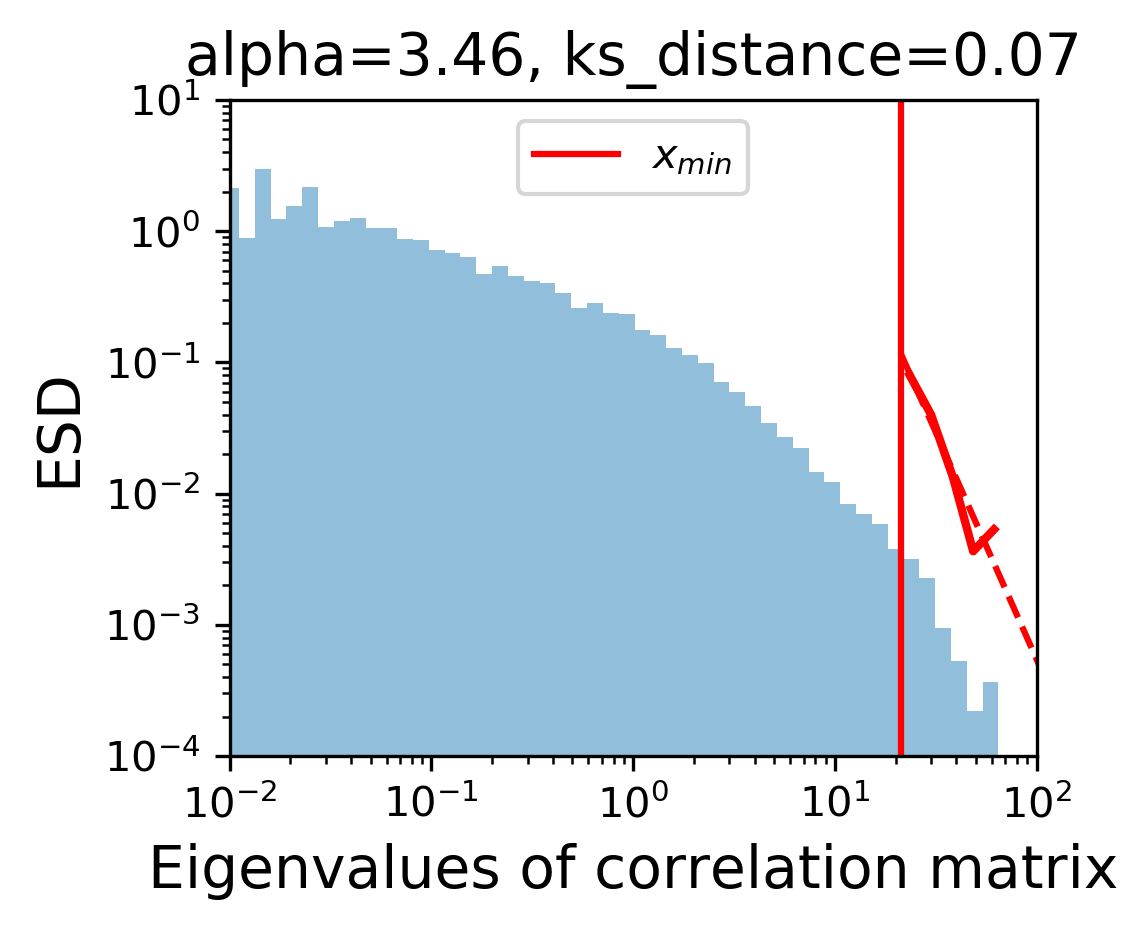

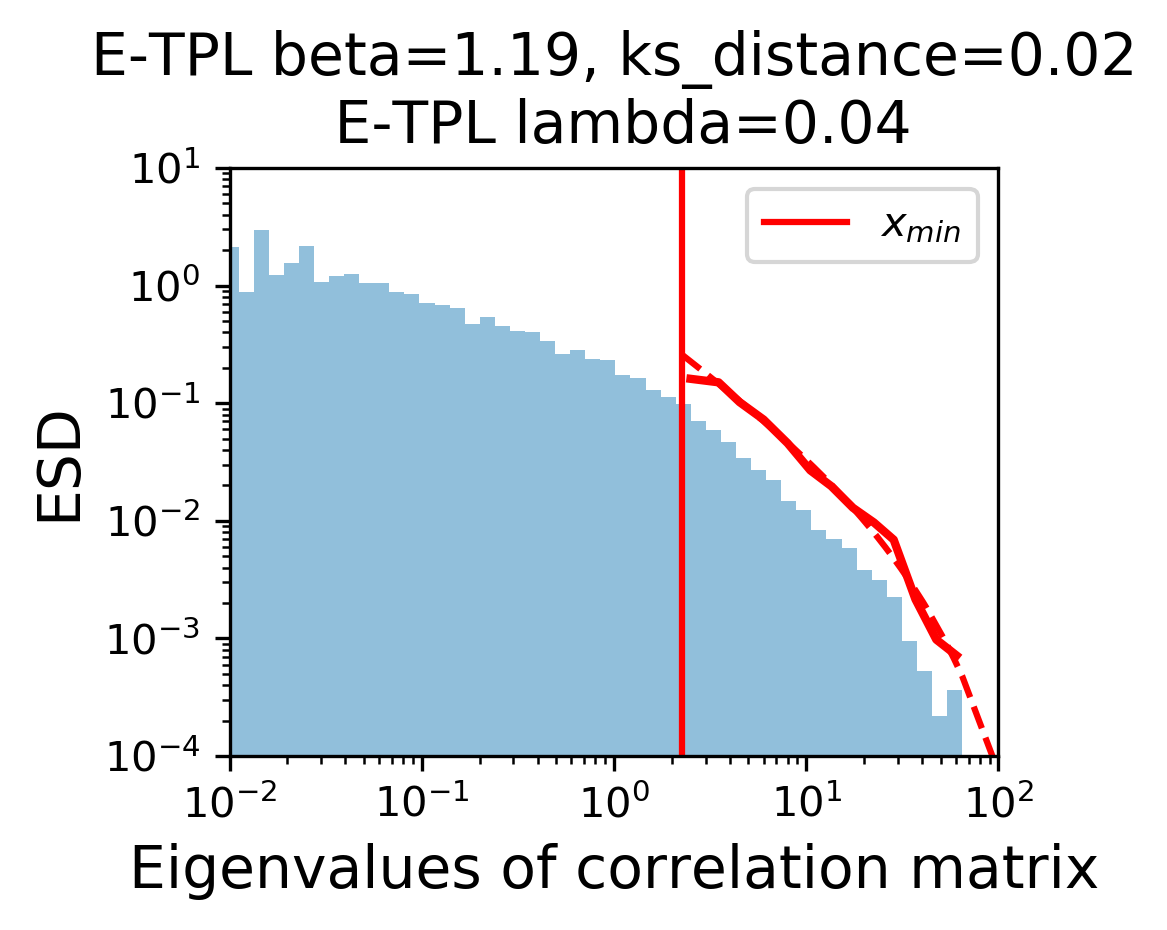

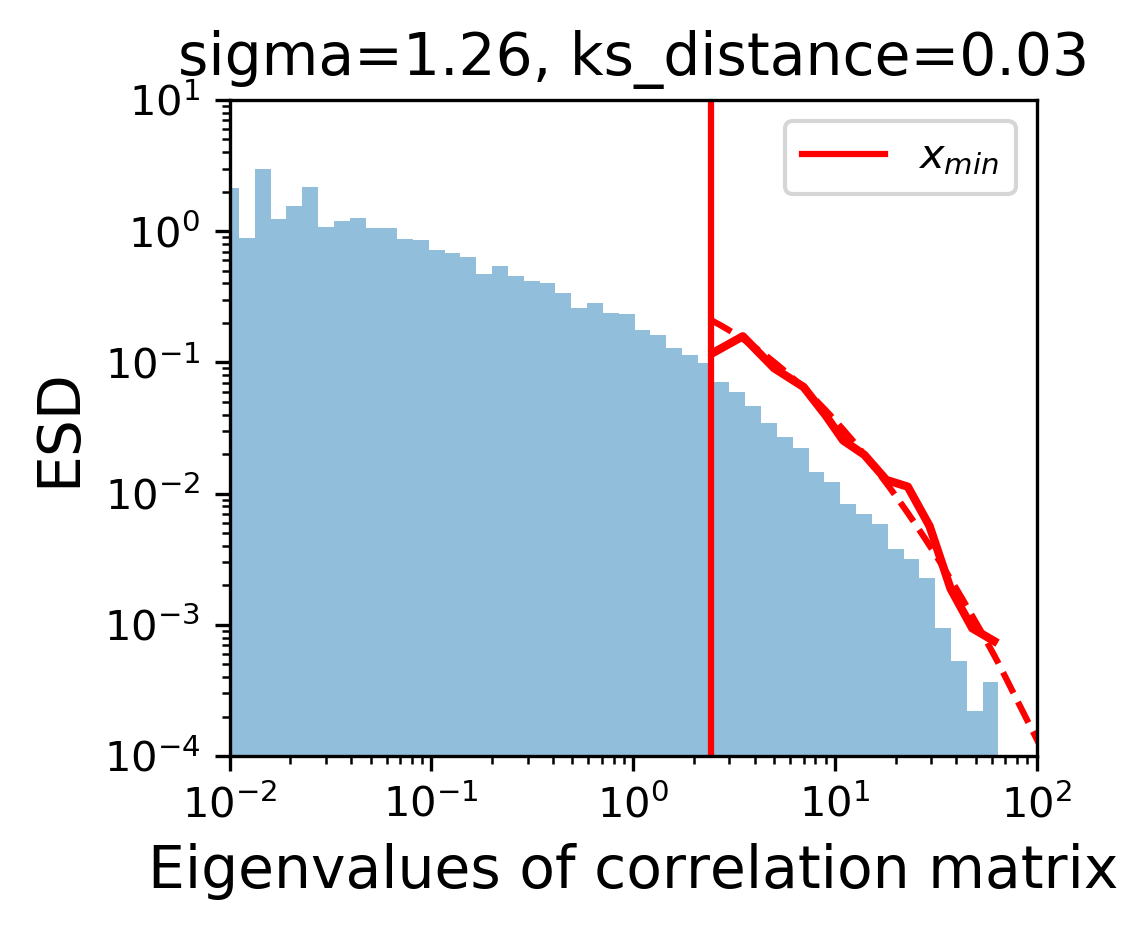

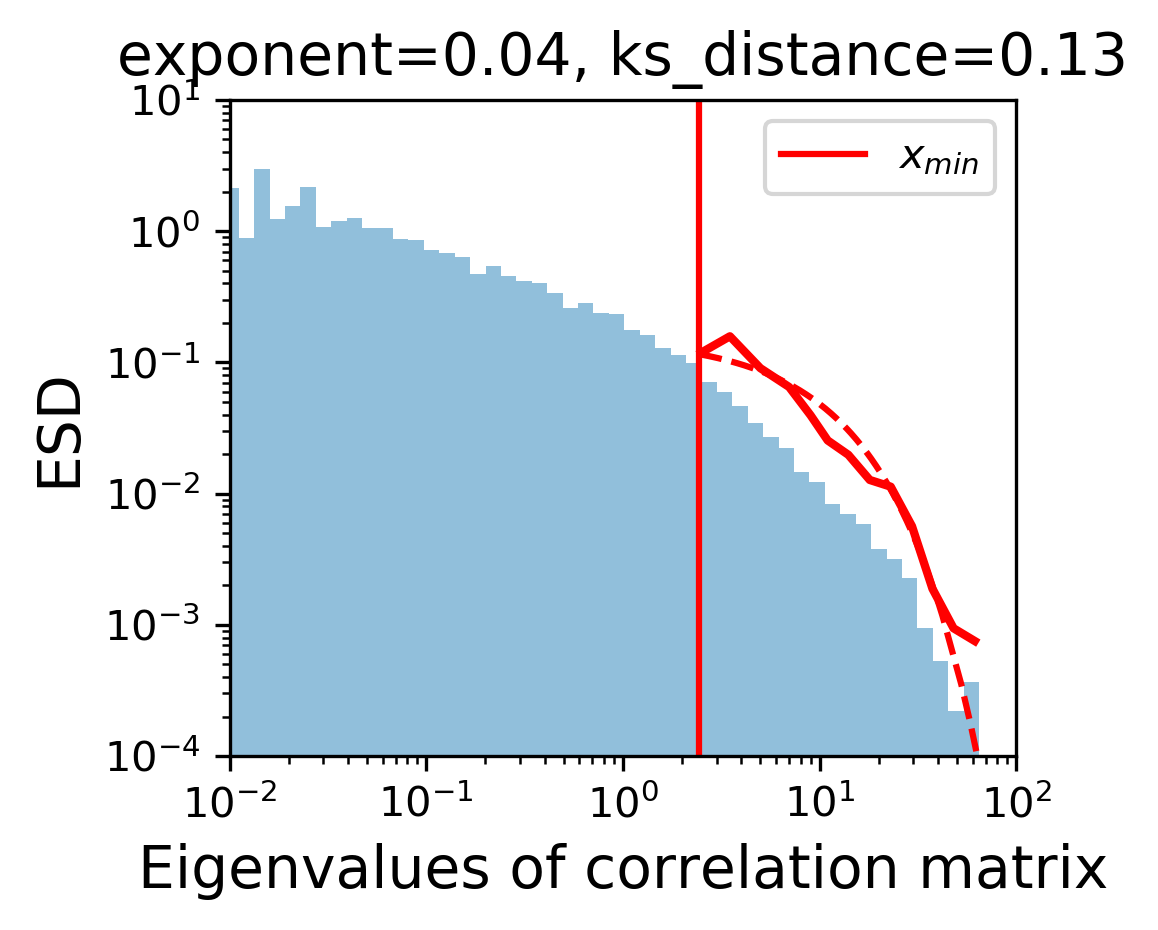

<Figure size 1920x1440 with 0 Axes>

In [8]:
for id, distribution in zip(range(4), distributions):    
    plot_result_new(distribution, id, fig_title='results/TPL_vs_PL_mediocre', xlim=[0.01, 100])

# Bad PL fitting

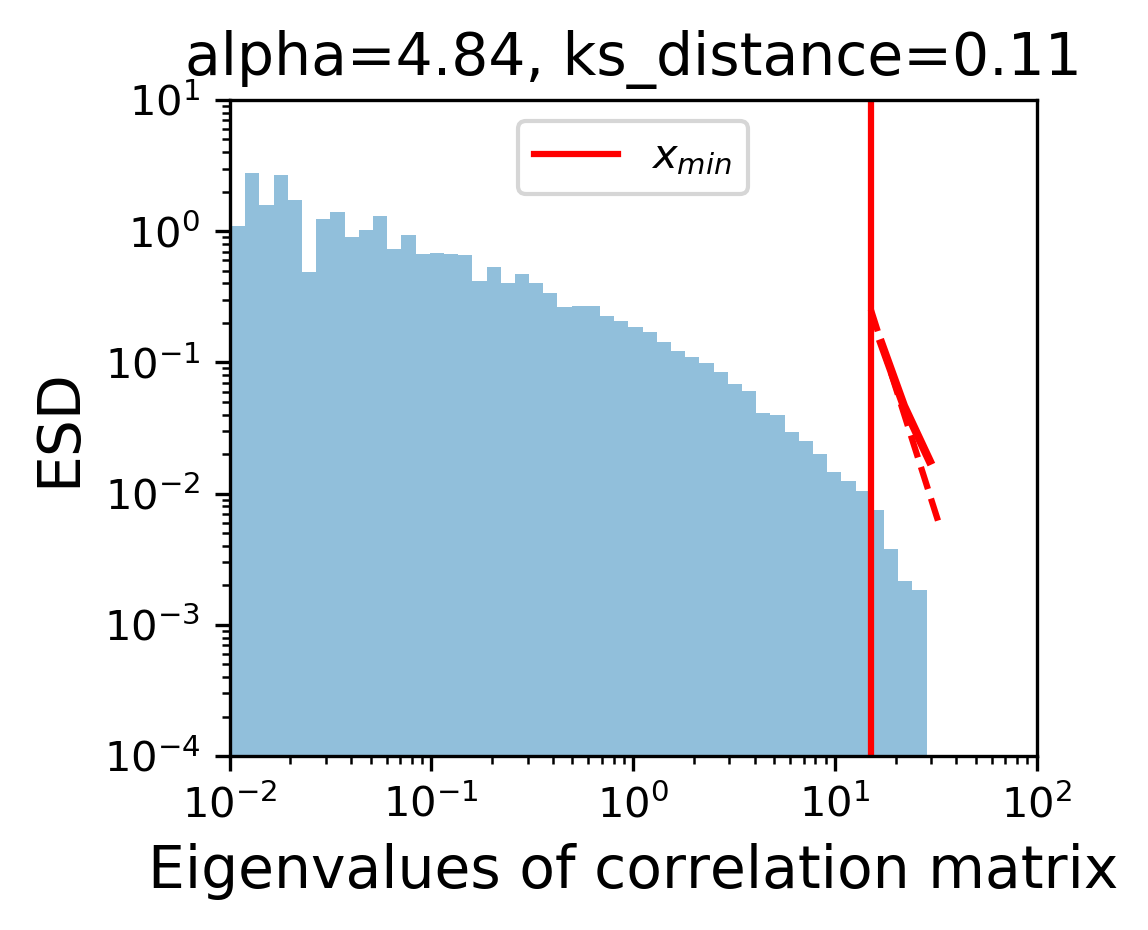

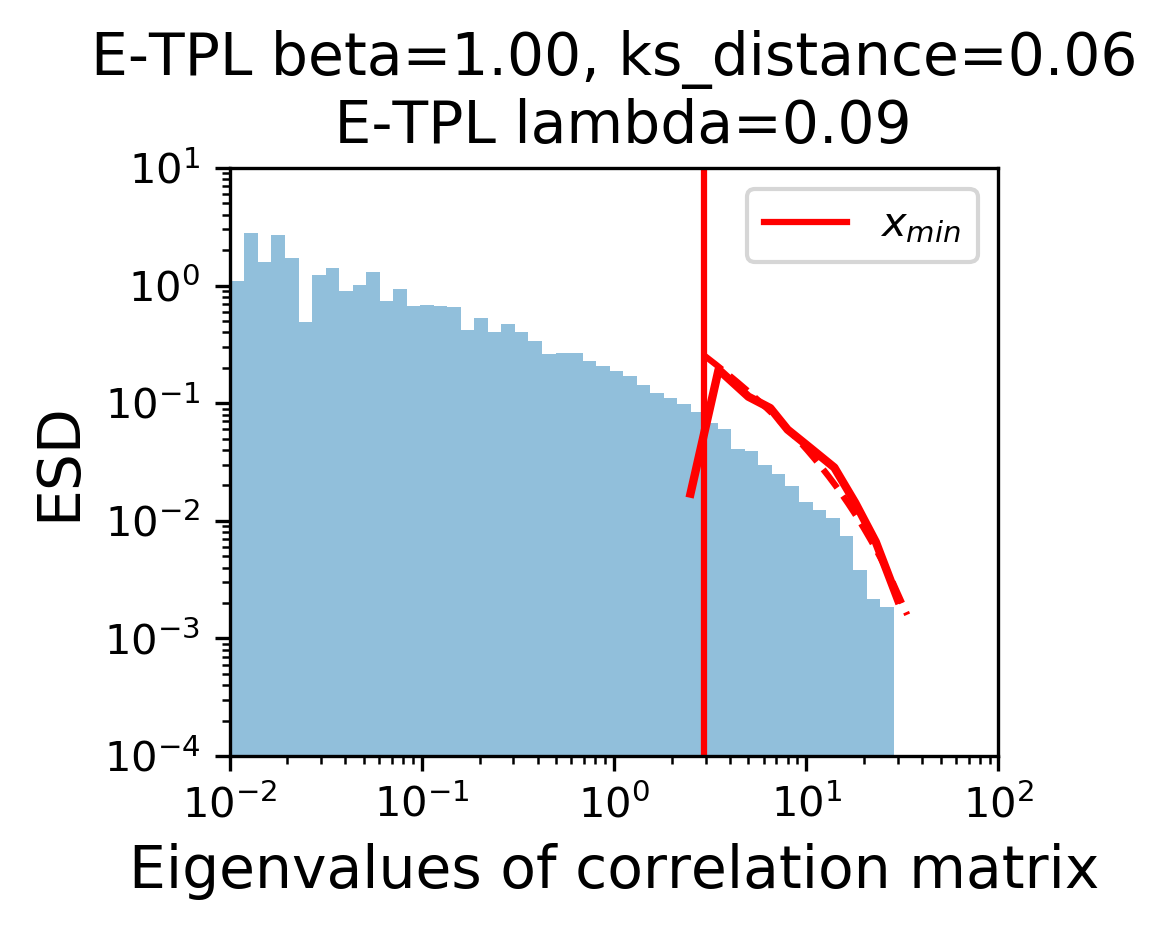

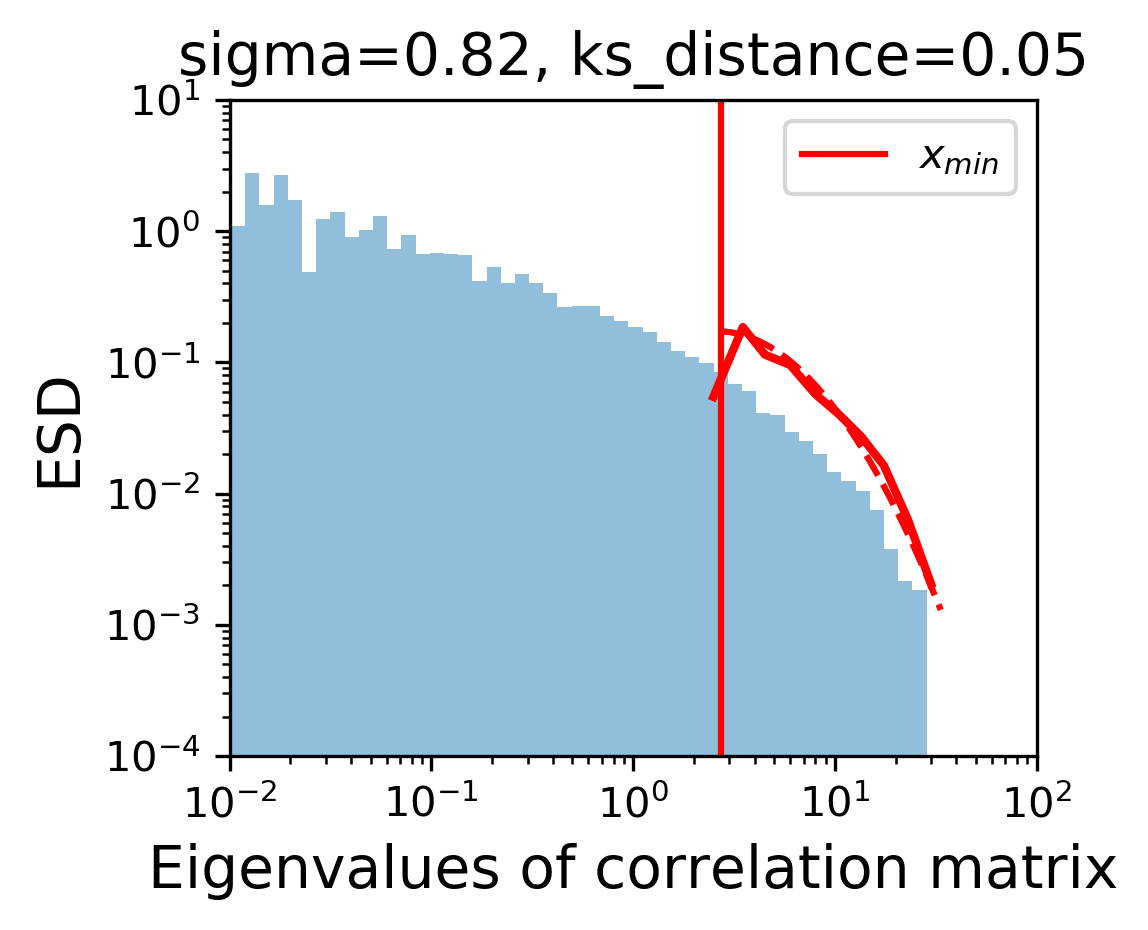

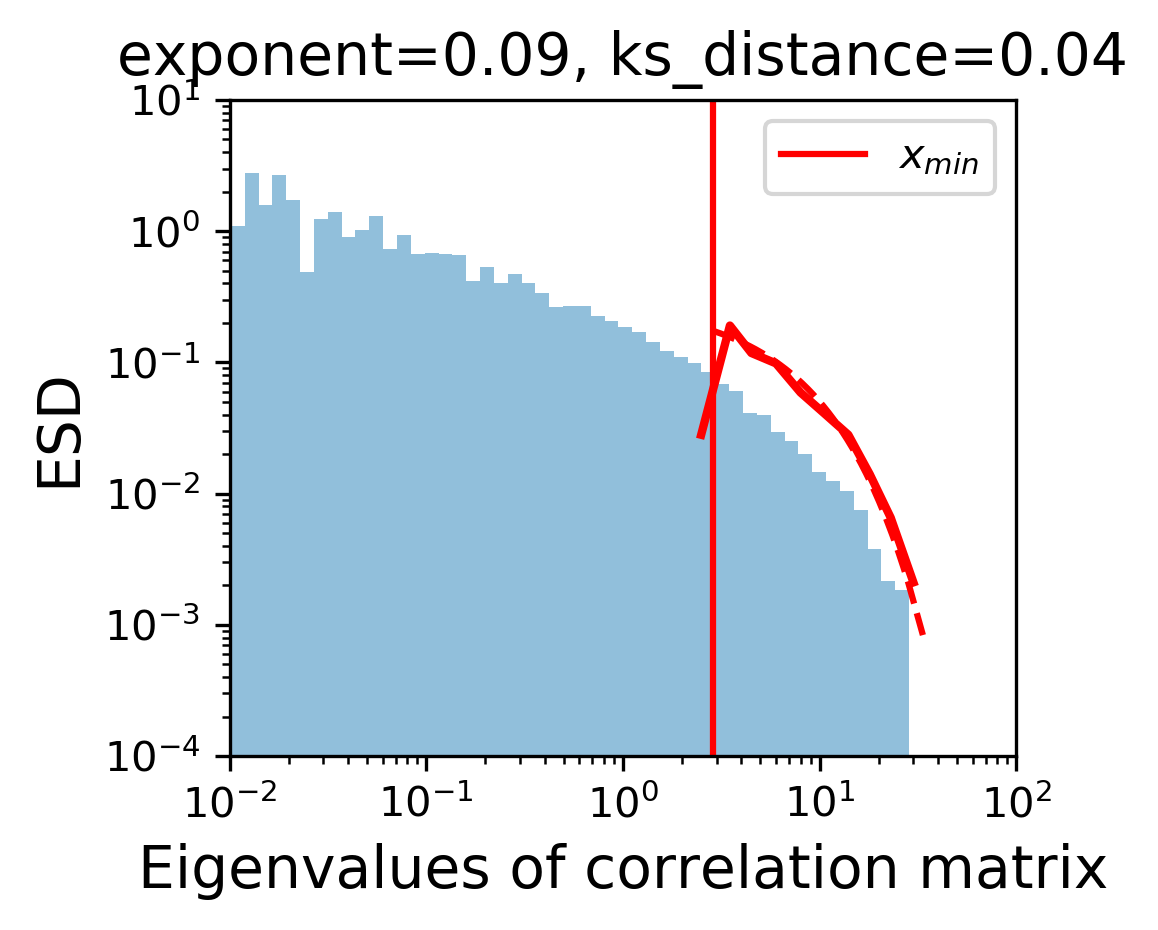

<Figure size 1920x1440 with 0 Axes>

In [9]:
for id, distribution in zip(range(4), distributions):    
    plot_result_new(distribution, id, fig_title='results/TPL_vs_PL_bad', xlim=[0.01, 100])